In [1]:
import os
os.sys.path.append("../src")

import colorsys
import random
import numpy as np
from dataset.dataset_interface import DatasetInterface
from pathlib import Path
from matplotlib import pyplot as plt
from utils.visualization_utils import to_rgb
import cv2

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

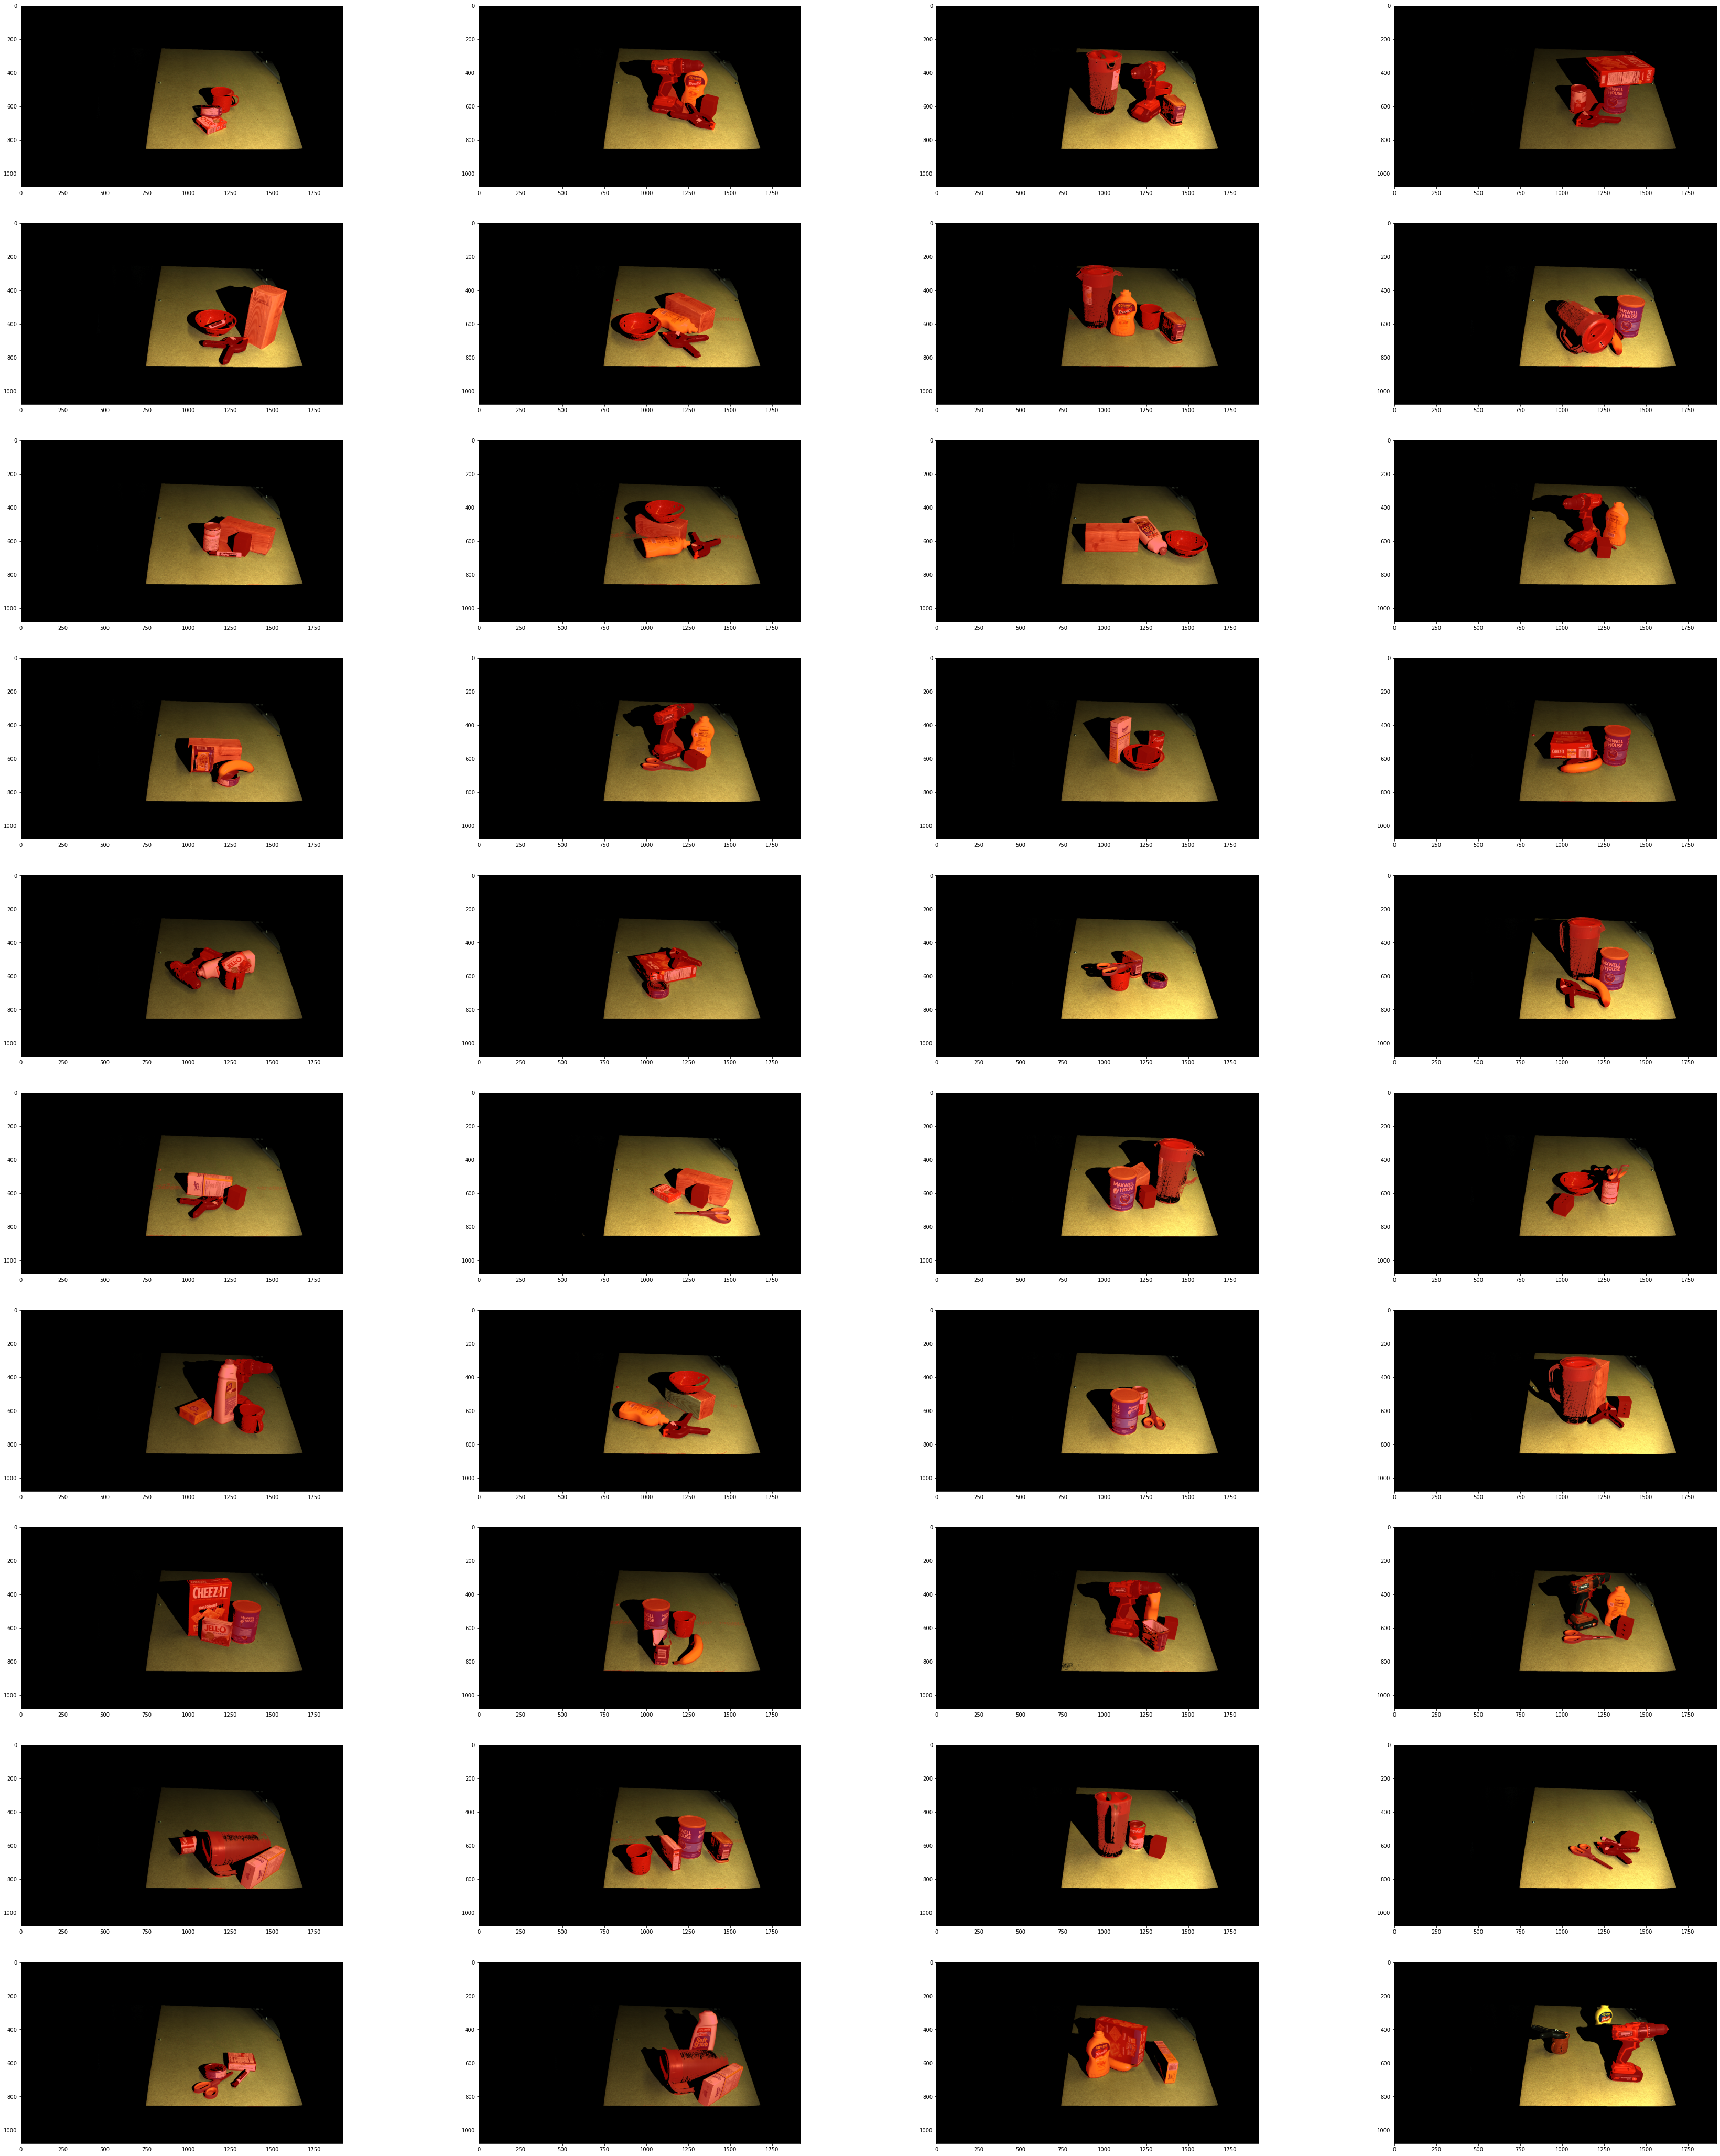

In [2]:
import math

in_path = Path("../resources/images/calibrated_masked_rg/not-cropped/ycb_video")
files = DatasetInterface.get_paths_in_dir(in_path, recursive=True)
assert len(files) > 0, "no files in path"

random.shuffle(files)
selected_files = files[:40]
columns = 4
rows = math.ceil(len(selected_files) / columns)

_, ax = plt.subplots(rows, columns, figsize=(columns * 15, rows * 7.5))

for idx, file in enumerate(selected_files):
    column = idx % columns
    row = (idx - column) // columns
    rs_rgb, rs_depth, zv_rgb, zv_depth, masks = DatasetInterface.load(file)

    if len(masks.shape) == 2:
        masks = masks[..., None]
    num_masks = masks.shape[2]
    colors = random_colors(num_masks)
    masked_image = zv_rgb.copy()
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    for i in range(num_masks):
        mask = masks[:, :, i]
        color = colors[i]
        masked_image = apply_mask(masked_image, mask, color)

    ax[row][column].imshow(masked_image)